# 3. Method 2: De Novo Sequencing with Transformers (Casanovo)

## 3.1 The Problem: What if there's no database?

In the previous notebook, we used **spectral hashing** to cluster spectra and match them against a database. But what happens when:
- You're studying a new organism with no reference proteome?
- You want to discover novel peptides or variants not in any database?
- You need to identify antibodies or other highly variable sequences?

**De novo sequencing** solves this by predicting the peptide sequence directly from the spectrum — no database required.

Casanovo implements a **classifier model,** where a machine learning algorithm is used to translate a sequence of peaks (made up of m/z and intensity value pairs) in a given spectrum into a sequence of amino acids of the generating peptide.

We start by encoding the peaks to store their relative position to one another (based on m/z value). Then, given a peak's relative positioning, Casanovo associates that peak with its potential amino acids. So, how does the actual encoding work?


---

## 3.2 The Approach: Sequence-to-Sequence Translation

Casanovo treats peptide identification as a **translation problem**:

| Language Translation | De Novo Sequencing |
|---------------------|-------------------|
| Input: English sentence | Input: MS/MS spectrum (peaks) |
| Output: Spanish sentence | Output: Peptide sequence (amino acids) |
| "The cat sat on the mat" → "El gato se sentó en la alfombra" | [peaks at 147.1, 260.2, ...] → "PEPTIDE" |

A translator must understand grammar, word relationships, and context, and so Casanovo must understand:
- **Peak relationships**: Which peaks are b-ions vs y-ions? Which are noise?
- **Mass differences**: A gap of 129 Da suggests glutamic acid (E)
- **Sequence context**: Certain amino acids are more likely to follow others

---

## 3.3 The (Extended) Lego Analogy: Reading Assembly Instructions Backwards

Imagine you find a completed Lego structure, but you've lost the instructions. You need to figure out the original build sequence.

**The naive approach:**
- Look at the final structure
- Try every possible disassembly order until you find one that makes sense

**The Casanovo approach:**
- Look at the "joints" between pieces (like mass differences between peaks)
- Use pattern recognition: "2x4 bricks usually connect to flat plates here"
- Literally build up the sequence, one brick at a time, with pattern recognition as "intuition"

> Just like an experienced Lego builder recognizes common substructures, Casanovo learns patterns from millions of spectra to predict the most likely next amino acid.

---

## 3.4 Why Positional Encoding Matters

The question we will solve is, **How does Casanovo learn where each peak is?**
- What understanding does it have about this peak, and peaks relative to this one? 

When you read "THE CAT SAT", the position of each word matters:
- "CAT THE SAT" is nonsense
- Position encodes meaning

Similarly, for spectra:
- A peak at m/z = 147 means something different than a peak at m/z = 647
- The *absolute position* (m/z value) and *relative positions* (gaps between peaks) both carry information

**Positional encoding** is how we teach the model to understand position. It converts each m/z value into a rich, multi-dimensional representation that captures both:
1. **Fine-scale differences**: Distinguishing m/z = 600.0 from m/z = 600.1 (isotope patterns)
2. **Coarse-scale structure**: Understanding that m/z = 200 and m/z = 800 are in different regions of the spectrum

This is easily represented with visuals, and we'll understand this concept with toy examples, as well as code implementations later.

## 3.5 The Full Pipeline: From Spectrum to Peptide

Before diving into the math, let's get a full view of what Casanovo does:

```
┌─────────────────┐     ┌──────────────────┐     ┌─────────────────┐     ┌────────────┐
│   MS/MS Peaks   │ ──► │ Positional       │ ──► │   Transformer   │ ──► │  Peptide   │
│  (m/z, int)     │     │ Encoding         │     │   Decoder       │     │  Sequence  │
└─────────────────┘     └──────────────────┘     └─────────────────┘     └────────────┘
     [147.1, ...]           [512-dim vectors]        attention +            "PEPTIDEK"
                                                     beam search
```

**Step 1: Positional Encoding** (this notebook's focus)
- Each peak's m/z value is transformed into a 512-dimensional vector
- Uses sine and cosine waves at multiple frequencies (wavelengths)
- Captures both fine and coarse positional information
 
**Step 2: Transformer Encoder-Decoder**
- Encoder: Processes all peak encodings together, learning relationships
- Decoder: Generates amino acids one at a time, conditioned on previous predictions

**Step 3: Beam Search**
- Instead of greedily picking the most likely amino acid, keeps top-k candidates
- Prunes candidates that exceed precursor mass tolerance
- Outputs the highest-probability complete sequence

---

Let's dive into step 1.


---

# Part I: Understanding Positional Encoding

## 3.6 The Math Behind the Waves

Casanovo's positional encoding transforms each m/z value into a 512-dimensional vector using sine and cosine waves. Let's build up to the full equation step by step. This is really not as complicated as it sounds.

![Each m/z value, m_j, is projected into 512 dimensions](CasanovoEncoding.png)




Do you remember this equation from high school? It's the general form of a sine wave:

$$
y = A\sin\big(B(x - h)\big) + k
$$

$$
\begin{aligned}
\text{Amplitude} &= |A|, \\
\text{Midline} &= y=k, \\
\text{Period} &= \frac{2\pi}{|B|}\ \text{ (or } \frac{360^\circ}{|B|}\text{)}, \\
\text{Phase shift} &= 
\begin{cases}
\text{right } h & \text{if } (h < 0),\\
\text{left } h & \text{if } (h > 0).
\end{cases}
\end{aligned}
$$

---

### 3.6.1 A Numerical Example

Consider this sine wave: $\sin\left(\frac{x}{(0.001/2\pi)(10,000/0.001)^{1/2}}\right)$

We can calculate the period:
$$ 
\text{Period} = \frac{2\pi}{B} \text{ where } B = \frac{1}{\left(\frac{0.001}{2\pi}\right)\left(\frac{10000}{0.001}\right)^{1/2}} = 2\pi \times \left(\frac{0.001}{2\pi}\right) \times 3162.277 = 3.162277
$$

So this sine wave completes one full cycle every ~3.16 m/z units.

![A single period plotted for this sine wave](desmos_1.png)

---

### 3.6.2 The Wavelength Concept

Now imagine a list of 256 wavelengths $\lambda_i$ spanning from $0.001$ to $10000$, increasing exponentially:
$$\lambda = [0.001, \dots, 10000]$$

Each wavelength defines a different "ruler" for measuring position — some with very fine ticks (short wavelengths), others with very coarse ticks (long wavelengths).

---

## 3.7 Breaking Down the Formula

Let's focus on just the sine component:

$$
f_i(m_j) = \sin\left(\frac{m_j}{(\lambda_{\min}/2\pi)\times(\lambda_{\max}/\lambda_{\min})^{i/(\dim-1)}}\right) \quad \text{for } i < 256
$$

Where:
- $m_j$ is the $j$-th peak's m/z value
- $\dim = 512$ (total dimensions: 256 sine + 256 cosine)
- $\lambda_{\min} = 0.001$ and $\lambda_{\max} = 10000$

The denominator simplifies to our wavelength $\lambda_i$:

$$
f_i(m_j) = \sin\left(\frac{m_j}{\lambda_i}\right) \quad \text{where } \lambda_i = \left(\frac{\lambda_{\min}}{2\pi}\right)\left(\frac{\lambda_{\max}}{\lambda_{\min}}\right)^{\frac{i}{d_{\sin}-1}}
$$

---

### 3.7.1 Why Include $2\pi$ in the Formula?

The $2\pi$ in the denominator is elegant! When we calculate the period:

$$
\text{Period} = 2\pi \times \lambda_i = 2\pi \times \left(\frac{\lambda_{\min}}{2\pi}\right)\left(\frac{\lambda_{\max}}{\lambda_{\min}}\right)^{\frac{i}{d_{\sin}-1}}
$$

The $2\pi$ terms cancel, giving us:

$$
\text{Period} = \lambda_{\min} \times \left(\frac{\lambda_{\max}}{\lambda_{\min}}\right)^{\frac{i}{d_{\sin}-1}}
$$

As $i$ increases from 0 to 255, the period grows exponentially from $\lambda_{\min}$ to $\lambda_{\max}$.

---

### 3.7.2 Low-Dimensional Example

Let's compute 6 wavelengths (instead of 256) to see the pattern:

$\lambda_i = \frac{\lambda_{\min}}{2\pi} \times \left(\frac{\lambda_{\max}}{\lambda_{\min}}\right)^{\frac{i}{5}}$

$$
\begin{aligned}
\lambda_0 &= \frac{0.001}{2\pi} \times 1 = \frac{0.001}{2\pi} \\
\lambda_1 &= \frac{0.001}{2\pi} \times 15.85 = \frac{0.0158}{2\pi} \\
\lambda_2 &= \frac{0.001}{2\pi} \times 251.19 = \frac{0.251}{2\pi} \\
\lambda_3 &= \frac{0.001}{2\pi} \times 3981.07 = \frac{3.981}{2\pi} \\
\lambda_4 &= \frac{0.001}{2\pi} \times 63095.73 = \frac{63.095}{2\pi} \\
\lambda_5 &= \frac{0.001}{2\pi} \times 1000000 = \frac{1000}{2\pi}
\end{aligned}
$$

Notice the exponential growth! Each wavelength is roughly 10-16× larger than the previous one.

---

### 3.7.3 Visualizing the Waves

Here are 5 sine waves at different wavelengths (notice we ommitted $\lambda_0$)

<img src="image2.png" alt="Multiple wavelengths" width="1200"/>

Zooming in:

<img src="image.png" alt="Zoomed wavelengths" width="500"/>

At m/z = 600, each wave gives a different value. ($\lambda_0 \text{ and } \lambda_1$ (red) ommited for visibility)

![Waves at m/z = 600](image3.png)

> **Understanding check:** Why did we exclude the red wave, $\lambda_0$ from the plot?
>
> <details>
> <summary>Click to see answer</summary>
> 
> The wavelength at $i=0$ is $\lambda_0 = \frac{0.001}{2\pi}$, which is extremely small. This creates a sine wave that oscillates so rapidly at typical m/z values (like 600) that it becomes practically invisible — just a blur.
> </details>

**Desmos link for all graphs:** https://www.desmos.com/calculator/he8fjmng6v

## 3.8 How Waves Capture Position: Fine vs. Coarse Resolution

Let's trace what happens as we move from m/z = 600 to 601:

![600 to 601](relativeDifferences.png)

Take note of how the blue "line" BARELY moves cyclically? And the Red/Green waves cycle all the time? This allows us to take note of how close (only different by Red/Green) or how far(different by Black/Blue, else just noise) one peak is from another.

| Wave | Period | Cycles from 600→601 | Sensitivity |
|------|--------|---------------------|-------------|
| Red (finest) | ~0.016! | ~63 cycles | Detects tiny shifts |
| Green | ~0.25 | ~4 cycles | Detects small shifts |
| Purple | ~3.98 | ~0.25 cycles | Detects moderate shifts |
| Black | ~63.1 | ~0.016 cycles | Detects large shifts |
| Blue (coarsest) | ~1000 | ~0.001 cycles | Distinguishes spectrum regions |

**The multi-scale intuition:**
- **Fine waves** (short periods) = microscope → distinguish isotopes, detect noise
- **Coarse waves** (long periods) = map → identify spectrum region, peptide class


Here's the encoding for m/z = 600 vs 601 at each wavelength:

$$
\begin{aligned}
\text{Peak } m/z = 600: \quad &[\lambda_1, \lambda_2, \lambda_3, \lambda_4, \lambda_5] \\
&= [0.364, -0.782, -0.973, -0.059, -0.588] \\[0.5em]
\text{Peak } m/z = 601: \quad &[\lambda_1, \lambda_2, \lambda_3, \lambda_4, \lambda_5] \\
&= [-0.227, -0.703, -0.222, -0.158, -0.593]
\end{aligned}
$$

Notice how the fine wavelengths ($\lambda_1$, $\lambda_2$) change dramatically, while coarse wavelengths ($\lambda_5$) barely move!

## 3.9 Why Both Sine AND Cosine?

You may have noticed the encoding uses both sine and cosine. This isn't just for more dimensions, it enables something crucial: **linear transformations between positions**.

Throughout this explanation, you may have seen various references to "we'll just focus on the sine part of the equation for now" (see full positional encoding equation image for reference). The reason we use both sine and cosine is elegant: it allows the model to compute relative positions using simple linear algebra.

---

### 3.9.1 Mathematical Insight

For the model to understand relative positions, it needs to compute transformations like:
$$A^{(k)} \cdot \text{PE}(m_j) = \text{PE}(m_j + k)$$

Where $A^{(k)}$ is a matrix that depends only on the offset $k$, not the position $m_j$.

**Why this matters:** Whether you're at m/z = 100 or m/z = 1000, the transformation "shift by 50 Da" uses the same matrix. This gives the model a universal way to understand relative distances.

**Basic intuition:** Encoding with sine AND cosine, not one or the other, allows us to make a transformation from one peak to peak + $k$ for some constant $k$. The model needs this transformation (represented as a matrix) to understand relative differences between points. In a nonrigorous sense, if we have points $a$, $b$, and $c$, all different by $k$, such that $a+k = b$, $b+k = c$, and $a + 2k = c$, then our model understands that these points are the same distance apart because they differ by $k$. Essentially, we rewrite our points as offsets to that point. 

$A^{(k)}$ is also invertible, meaning that taking $(A^{(k)})^{-1}$ allows you to reverse the transformation and shift backwards by $k$ units.

> **Lego analogy:** If piece A is 3 studs to the right of piece B, and piece C is 3 studs to the right of piece D, the model understands both relationships the same way, without needing to know where on the baseplate they are.

---


### 3.9.2 Why Sine Alone Fails

If we only had the sine component $\begin{bmatrix} \sin(m_j/\lambda_i) \\ 0 \end{bmatrix}$, we'd be trying to represent a 2D rotation using only a 1D line (the x-axis). You can't rotate a point if you've collapsed it onto a single axis—the transformation becomes "degenerate".

So now why do we actually need both sine AND cosine? We don't want to discard one of our axes. Take $\begin{bmatrix} 2 \\ 4 \end{bmatrix}$ on the cartesian plane. This is embedded with both $x$ and $y$ axes. If we just had $\begin{bmatrix} x \\ 0 \end{bmatrix}$ and wanted to get to $\begin{bmatrix} 2 \\ 4 \end{bmatrix}$, how would we get there? Well, we don't know, because we don't know our $x$ value. Now if we have $\begin{bmatrix} 1 \\ 0 \end{bmatrix}$ and wanted to get to $\begin{bmatrix} 2 \\ 4 \end{bmatrix}$, that requires $\begin{bmatrix} 1 \\ 0 \end{bmatrix} + \begin{bmatrix} 1 \\ 4 \end{bmatrix} = \begin{bmatrix} 2 \\ 4 \end{bmatrix}$. Discarding the cosine values is analogous to discarding the x axis.


**The Rotation Requires Two Coordinates:**
Think of each wavelength $\lambda_i$ as defining a 2D plane. At wavelength $\lambda_i$, we encode position $m_j$ as a point in 2D space:

- For each peak $m_j$:
    - For each wavelength $\lambda_i$:
        - Encode the peak at wavelength $i$ in 2 dimensions: sine and cosine

$$
\begin{bmatrix}
\sin(m_j/\lambda_i) \\
\cos(m_j/\lambda_i)
\end{bmatrix}
$$

This point lies on the unit circle. Moving from position $m_j$ to position $m_j + k$ corresponds to rotating this point by angle $k/\lambda_i$ around the origin.


---

### 3.9.3 [Optional] The Rotation Matrix

We need to show that $A^{(k)}$ is a **rotation matrix**. For each wavelength $\lambda_i$, the corresponding 2×2 block in $A^{(k)}$ looks like:

$$
A^{(k)} = \begin{bmatrix}
\cos(k/\lambda_i) & -\sin(k/\lambda_i) \\
\sin(k/\lambda_i) & \cos(k/\lambda_i)
\end{bmatrix}
$$

This is the standard 2D rotation matrix that rotates a point by angle $\theta = k/\lambda_i$. Here's why this only works when we have **both** sine and cosine:


---


### 3.9.4 [Optional] The Math: Rotation Matrix Multiplication

When we multiply the rotation matrix $A^{(k)}$ by our encoding vector, we get: 

$$
\begin{bmatrix}
\cos(k/\lambda_i) & -\sin(k/\lambda_i) \\
\sin(k/\lambda_i) & \cos(k/\lambda_i)
\end{bmatrix}
\begin{bmatrix}
\sin(m_j/\lambda_i) \\
\cos(m_j/\lambda_i)
\end{bmatrix}
=
\begin{bmatrix}
\sin(m_j/\lambda_i)\cos(k/\lambda_i) - \cos(m_j/\lambda_i)\sin(k/\lambda_i) \\
\sin(m_j/\lambda_i)\sin(k/\lambda_i) + \cos(m_j/\lambda_i)\cos(k/\lambda_i)
\end{bmatrix}
$$

Using the angle addition formulas:
$$\sin(a+b) = \sin(a)\cos(b) + \cos(a)\sin(b)$$
$$\cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b)$$

This turns into:
$$
=
\begin{bmatrix}
\sin((m_j + k)/\lambda_i) \\
\cos((m_j + k)/\lambda_i)
\end{bmatrix}
$$

Notice that to compute $\sin((m_j + k)/\lambda_i)$, the formula requires **both** $\sin(m_j/\lambda_i)$ and $\cos(m_j/\lambda_i)$. If we only encoded sine values, the $\cos(m_j/\lambda_i)$ term wouldn't exist, making the transformation a) nonlinear or b) dependent on the current position $m_j$, which contradicts the proposition that we create a matrix $A^{(k)}$ independent of $m_j$.

**Full proof:** [Linear Relationships in Positional Encoding](https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt


---

# Part II: Implementing Positional Encoding

## 3.10 Code Implementation

The intuition + math was the hard part. Let's implement the positional encoding (in ~10 lines of code) and visualize how it works.

In [2]:
%pip install scikit-learn
import numpy as np
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Note that both sine and cosine encodings use the same list of wavelengths. A single set of 256 wavelengths is applied to compute both the sine and cosine components, giving us 512 total dimensions (256 sine + 256 cosine).

In [3]:
def make_wavelength_list(dimensions: int, lambda_min: float = 0.001, lambda_max: float = 10000) -> np.ndarray:
    """
    Generate wavelengths following the Casanovo formula:
    ꟛ_i = (ꟛ_min / 2π) * (ꟛ_max / ꟛ_min)^(i / (d_sin - 1))
    
    Args:
        d_model: Total dimensions (split evenly between sin/cos)
        lambda_min: Minimum wavelength (default: 0.001, as in Casanovo)
        lambda_max: Maximum wavelength (default: 10000, as in Casanovo)
    Returns: 
        Array of d_model // 2 wavelengths
    """
    d_sin = dimensions // 2
    wavelengths = np.zeros(d_sin)
    for i in range(d_sin):
        wavelengths[i] = (lambda_min / (2 * np.pi)) * (lambda_max / lambda_min) ** (i / (d_sin - 1))
    return wavelengths

# Let's see what wavelengths look like for 512 dimensions
wavelengths = make_wavelength_list(512)
print(f"Number of wavelengths: {len(wavelengths)}")
print(f"Smallest wavelength: {wavelengths[0]:.6f}")
print(f"Largest wavelength: {wavelengths[-1]:.6f}")
print(f"\nFirst 10 wavelengths: {wavelengths[:10]}")

Number of wavelengths: 256
Smallest wavelength: 0.000159
Largest wavelength: 1591.549431

First 10 wavelengths: [0.00015915 0.00016954 0.0001806  0.00019239 0.00020494 0.00021831
 0.00023256 0.00024773 0.00026389 0.00028111]


In [4]:
# Define positional encoding function used by Casanovo
# This function takes in 1 m/z value and returns a 512-dimensional positional encoding vector
# (this feels sort of like a reverse Fourier transform)
def positional_encoding(m_z, dimensions=512, lambda_min=0.001, lambda_max=10000):
    """
    Encode a single m/z value into a d_model-dimensional vector.
    
    First d_model/2 dimensions: sine encoding
    Last d_model/2 dimensions: cosine encoding
        
    Args:
        m_z: The m/z value to encode
        d_model: Total dimensionality of the encoding
        lambda_min, lambda_max: Wavelength range
    
    Returns:
        numpy array of shape (d_model,)
    """
    encoding = np.zeros(dimensions)
    d_sin = dimensions // 2
    wavelengths = make_wavelength_list(dimensions)
    for d in range(d_sin):
        wavelength = wavelengths[d]
        encoding[d] = np.sin(m_z / wavelength)           # First half: sine
        encoding[d + d_sin] = np.cos(m_z / wavelength)   # Second half: cosine
    
    return encoding

Let's go through a small, but very revealing example.

Similarity (dot product) comparisons:
  1000 vs 1000.1 (similar m/z):   151.82
  1000 vs 126.127 (different m/z): -13.13

→ Similar m/z values have higher dot products (more similar encodings)


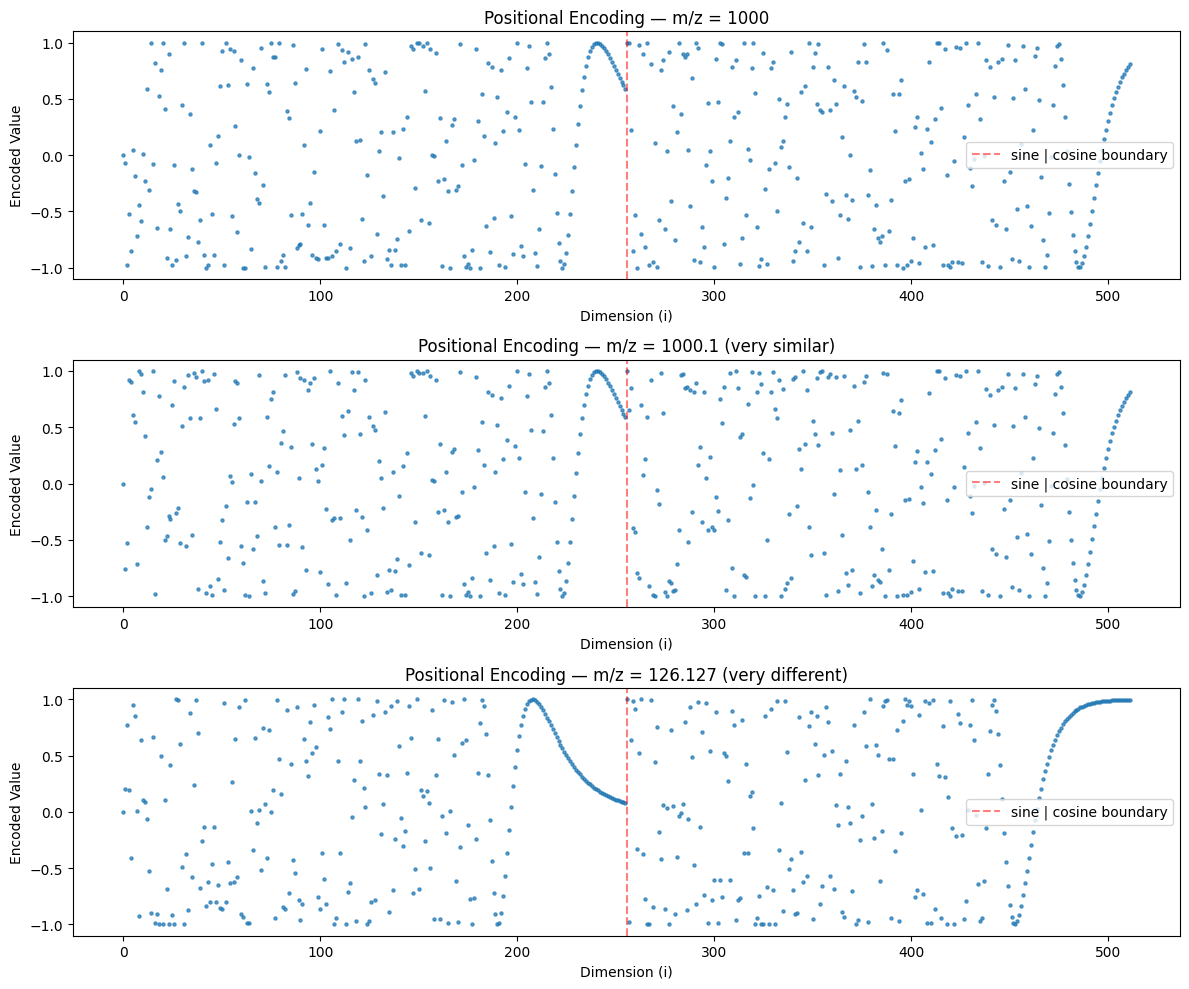

In [5]:
# Encode three different m/z values
encode_1000 = positional_encoding(1000)
encode_1000_1 = positional_encoding(1000.1)  # Very close to 1000
encode_126 = positional_encoding(126.127)    # Very different from 1000

# Check similarity using dot product
print("Similarity (dot product) comparisons:")
print(f"  1000 vs 1000.1 (similar m/z):   {np.dot(encode_1000, encode_1000_1):.2f}")
print(f"  1000 vs 126.127 (different m/z): {np.dot(encode_1000, encode_126):.2f}")
print("\n→ Similar m/z values have higher dot products (more similar encodings)")

# Visualize the encodings
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for ax, (enc, title) in zip(axes, [
    (encode_1000, "Positional Encoding — m/z = 1000"),
    (encode_1000_1, "Positional Encoding — m/z = 1000.1 (very similar)"),
    (encode_126, "Positional Encoding — m/z = 126.127 (very different)")
]):
    ax.scatter(range(len(enc)), enc, s=5, alpha=0.7)
    ax.axvline(x=256, color='red', linestyle='--', alpha=0.5, label='sine | cosine boundary')
    ax.set_title(title)
    ax.set_xlabel("Dimension (i)")
    ax.set_ylabel("Encoded Value")
    ax.legend()

plt.tight_layout()
plt.show()

### 3.10.1 Interpreting the Encoding Patterns

Looking at the scatter plots above, we can see a clear pattern:

| Dimension Range | Wavelength | Information Captured |
|-----------------|------------|---------------------|
| 0–50 (sine), 256–306 (cosine) | Short | High-resolution, changes rapidly with small m/z shifts |
| 200–255 (sine), 456–511 (cosine) | Long | Low-resolution, stable across nearby m/z values |

**Some Corollaries:**
- The left side of each plot (fine wavelengths) looks like noise. Recall our red wave? It was oscillating so fast that small m/z changes cause large value changes. Same idea here. Regardless of how fast it is though, more dimensions gives the model a clearer picture of what's happening at each m/z value.
- The right side (coarse wavelengths) shows smooth patterns - these change only for large m/z differences

Let's zoom in to see this more clearly:

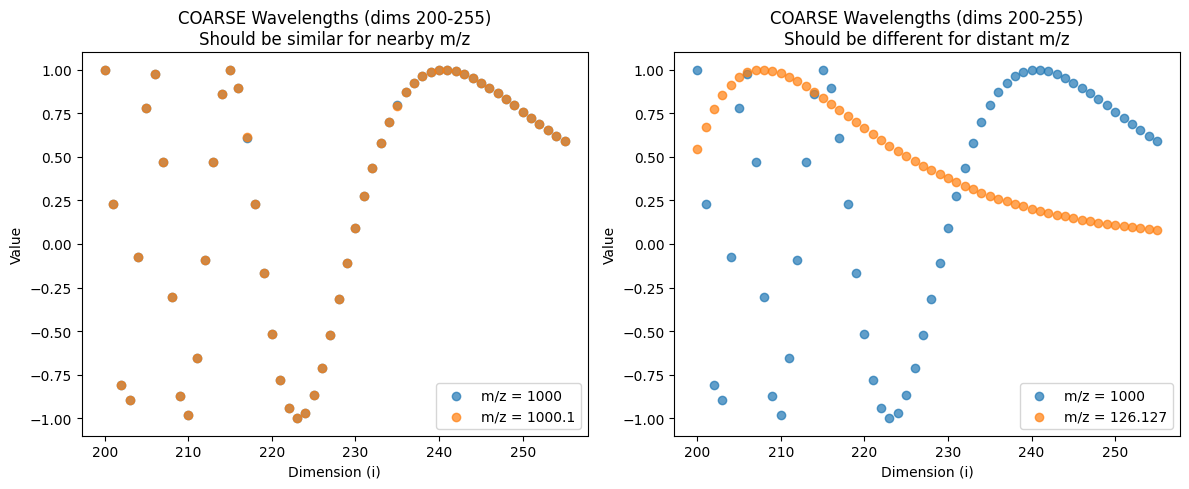

Cosine similarity in coarse dimensions:
  1000 vs 1000.1: 1.0000 (identical!)
  1000 vs 126.127: 0.0722 (very different)


In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Compare LOW-resolution dimensions (coarse wavelengths: 200-255)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(range(200, 256), encode_1000[200:256], label='m/z = 1000', alpha=0.7)
axes[0].scatter(range(200, 256), encode_1000_1[200:256], label='m/z = 1000.1', alpha=0.7)
axes[0].set_title("COARSE Wavelengths (dims 200-255)\nShould be similar for nearby m/z")
axes[0].set_xlabel("Dimension (i)")
axes[0].set_ylabel("Value")
axes[0].legend()

axes[1].scatter(range(200, 256), encode_1000[200:256], label='m/z = 1000', alpha=0.7)
axes[1].scatter(range(200, 256), encode_126[200:256], label='m/z = 126.127', alpha=0.7)
axes[1].set_title("COARSE Wavelengths (dims 200-255)\nShould be different for distant m/z")
axes[1].set_xlabel("Dimension (i)")
axes[1].set_ylabel("Value")
axes[1].legend()

plt.tight_layout()
plt.show()

# Quantify with cosine similarity
sim_nearby = cosine_similarity([encode_1000[200:256]], [encode_1000_1[200:256]])[0][0]
sim_distant = cosine_similarity([encode_1000[200:256]], [encode_126[200:256]])[0][0]
print(f"Cosine similarity in coarse dimensions:")
print(f"  1000 vs 1000.1: {sim_nearby:.4f} (identical!)")
print(f"  1000 vs 126.127: {sim_distant:.4f} (very different)")

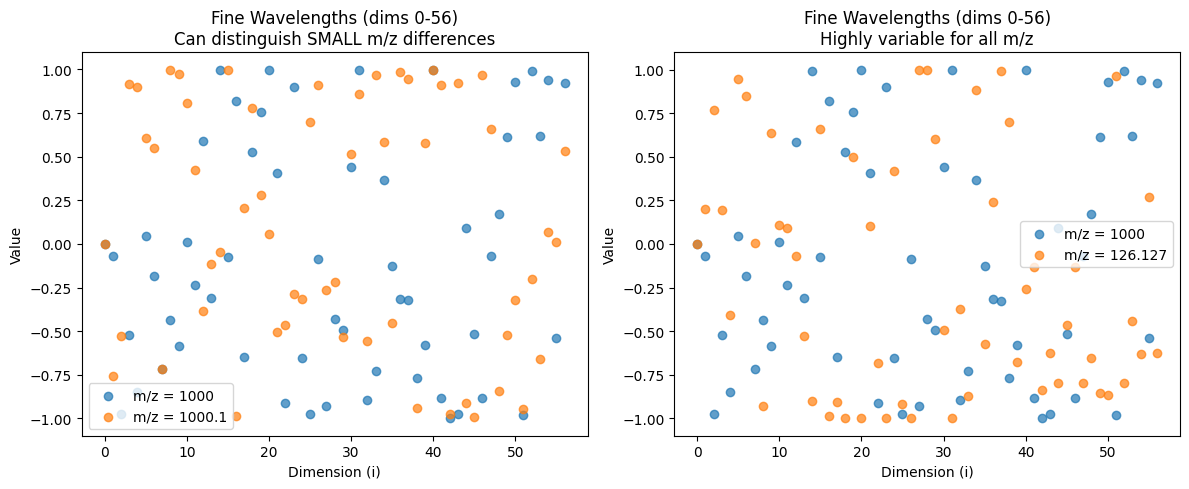

Cosine similarity in FINE dimensions (0-56):
  1000 vs 1000.1: -0.0410
  1000 vs 126.127: -0.2791

→ Fine wavelengths detect the 0.1 Da difference that coarse wavelengths missed!


In [7]:
# Compare HIGH-resolution dimensions (fine wavelengths: 0-56)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(range(0, 57), encode_1000[0:57], label='m/z = 1000', alpha=0.7)
axes[0].scatter(range(0, 57), encode_1000_1[0:57], label='m/z = 1000.1', alpha=0.7)
axes[0].set_title("Fine Wavelengths (dims 0-56)\nCan distinguish SMALL m/z differences")
axes[0].set_xlabel("Dimension (i)")
axes[0].set_ylabel("Value")
axes[0].legend()

axes[1].scatter(range(0, 57), encode_1000[0:57], label='m/z = 1000', alpha=0.7)
axes[1].scatter(range(0, 57), encode_126[0:57], label='m/z = 126.127', alpha=0.7)
axes[1].set_title("Fine Wavelengths (dims 0-56)\nHighly variable for all m/z")
axes[1].set_xlabel("Dimension (i)")
axes[1].set_ylabel("Value")
axes[1].legend()

plt.tight_layout()
plt.show()

# Quantify with cosine similarity
sim_nearby_fine = cosine_similarity([encode_1000[0:57]], [encode_1000_1[0:57]])[0][0]
sim_distant_fine = cosine_similarity([encode_1000[0:57]], [encode_126[0:57]])[0][0]
print(f"Cosine similarity in FINE dimensions (0-56):")
print(f"  1000 vs 1000.1: {sim_nearby_fine:.4f}")
print(f"  1000 vs 126.127: {sim_distant_fine:.4f}")
print(f"\n→ Fine wavelengths detect the 0.1 Da difference that coarse wavelengths missed!")


---

# Part III: From Encoding to Prediction

## 3.11 Casanovo's Transformer Architecture

Now that we understand how peaks are encoded, let's see how Casanovo uses these encodings to predict peptide sequences.

<img src='Casanovo Transformer Architecture.webp' width=500 height=500>

The model has three inputs:
1. **Encoded spectrum** — our 512-dimensional vectors for each peak
2. **Encoded precursor** — mass and charge of the intact peptide (sets the mass budget)
3. **Previously predicted amino acids** — enables autoregressive generation

---

## 3.12 The Translation Analogy

Casanovo works like a language translator, but for molecules:

### 3.12.1 Transformer Encoder-Decoder

| English → Spanish | Spectrum → Peptide |
|------------------|-------------------|
| Read English sentence | Read all peak encodings |
| Build encoded representation of meaning | Build representation of peak relationships |
| Decoder predicts first Spanish word | Decoder predicts first amino acid |
| Continue, conditioning on previous words | Continue, conditioning on previous amino acids |

**The first prediction is special:** Without previous amino acids, Casanovo uses the precursor mass/charge to make its first guess. Then each subsequent amino acid is predicted based on:
- All peak encodings (via attention)
- The sequence generated so far

---

### 3.12.2 Linear + Softmax Output

After the decoder produces a representation for the next position:

1. **Linear layer:** Computes a score for each of the ~27 possible outputs (20 amino acids + modifications + stop token)
2. **Softmax:** Converts scores to probabilities

Example output: `[Gly: 0.02, Ala: 0.05, ..., Lys: 0.71, ...]` → Predict **Lysine (K)**

---

### 3.12.3 Beam Search Decoding

> Beam Search is just a simple backtracking with a fancy name. 

Instead of greedily picking the most likely amino acid at each step, beam search keeps the **top-k** candidates:

<img src='Beam Search Ex.webp' alt="Beam search visualization" width=600 height=300>

**How it works:**
1. Start with k=5 partial sequences
2. Extend each by all possible amino acids
3. Keep only the top-k most probable extensions
4. Prune sequences that exceed precursor mass
5. When all sequences terminate, return the highest-probability one

**Example calculation:**
$$
\begin{aligned}
P(ABC) &= P(A) \times P(B|A) \times P(C|AB) \\
       &= 0.5 \times 0.4 \times 0.8 = 0.16 \\
P(AED) &= P(A) \times P(E|A) \times P(D|AE)  \\
       &= 0.5 \times 0.5 \times 0.8 = 0.20
\end{aligned}
$$

→ "AED" wins over "ABC" even though individual probabilities varied!

> Beam search finds the **globally best sequence**, not just locally optimal choices (greedy). This is crucial because amino acid probabilities depend heavily on context.

---

## 3.13 Summary: Why This Works

Let's connect everything back to the original problem:

### The Problem
We need to predict a peptide sequence from MS/MS peaks without a reference database.

### The Solution
1. **Positional Encoding** transforms raw m/z values into rich 512-dimensional vectors that:
   - Capture both fine-scale (isotopes) and coarse-scale (peptide regions) information
   - Enable linear transformations for learning relative positions
   - Allow the model to understand "this peak is 128 Da away from that one"

2. **Transformer Architecture** processes these encodings through:
   - Attention mechanisms that learn peak-to-peak relationships
   - Autoregressive decoding that builds sequences one amino acid at a time

3. **Beam Search** finds the globally optimal sequence by exploring multiple hypotheses simultaneously.

### The Lego Analogy (Complete)

| Step | Lego | Casanovo |
|------|------|----------|
| Representation | Measure each piece precisely | Encode each peak with multi-scale wavelengths |
| Pattern Recognition | "2x4 bricks connect to plates here" | "b-ions follow this pattern" |
| Sequential Assembly | Build one piece at a time | Predict one amino acid at a time |
| Quality Control | Check if pieces fit | Verify mass within tolerance |
| Backtracking | Try different assembly orders | Beam search explores alternatives |

---

## 3.14 Further Reading

- **Casanovo Paper:** [Sequence-to-sequence translation from mass spectra to peptides with a transformer model](https://www.nature.com/articles/s41467-024-49731-x)
- **Positional Encoding Deep Dive:** [Linear Relationships in Transformer Positional Encoding](https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/)
- **Original Transformer Architecture:** [Attention Is All You Need](https://arxiv.org/abs/1706.03762)